In [281]:
import os
from dotenv import load_dotenv

In [282]:
load_dotenv()

True

In [ ]:
import datetime as dt
from typing import Union, Dict, Set, List, TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
import yfinance as yf
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volume import volume_weighted_average_price
import traceback
import pandas as pd

In [284]:
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_PROJECT="Financial_stock_Eval"

In [285]:
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "Financial_stock_Eval"

In [286]:
from typing import Union, Dict, Set, List, TypedDict, Annotated
import pandas as pd
from langchain_core.tools import tool
import yfinance as yf
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volume import volume_weighted_average_price
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

In [287]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [288]:
llm.invoke("Hlo")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--de6e7b3d-a214-4839-9c82-e863b980c931-0', usage_metadata={'input_tokens': 3, 'output_tokens': 229, 'total_tokens': 232, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 220}})

To extract company name and ticker name

In [289]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Company extraction system
class CompanyExtraction(BaseModel):
    """Extract company name and stock symbol from user question."""
    
    company_name: str = Field(description="The company name mentioned in the question")
    stock_symbol: str = Field(description="The stock ticker symbol (e.g., TSLA, AAPL)")

structured_llm_extractor = llm.with_structured_output(CompanyExtraction)

company_extract_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an expert at extracting company names and stock symbols from user questions.
    Extract the company name and its corresponding stock ticker symbol from the user's question.
    If the user mentions a company name, provide the appropriate stock symbol.
    If the user mentions a stock symbol, provide the company name.
    
    Common examples:
    - Tesla/TSLA
    - Apple/AAPL  
    - Microsoft/MSFT
    - Amazon/AMZN
    - Google/Alphabet/GOOGL
    - Meta/Facebook/META
    - Netflix/NFLX
    - Nvidia/NVDA
    - AMD/AMD
    
    If you cannot identify a specific company, return "UNKNOWN" for both fields."""),
    ("human", "User question: {question}")
])


company_extractor = company_extract_prompt | structured_llm_extractor

To check whether given query by user is regarding financial stock or not

In [290]:
class GradeQuestion(BaseModel):
    """Binary score for relevance check on Question given by user whether is it valid financial stock related Question or Not."""

    binary_score: str = Field(
        description="Question are relavant to stock, 'yes' or 'no'"
    )

In [291]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeQuestion)
# Prompt
system = """You are a grader assessing relevance of a user question. \n 
    If the user question contains keyword(s) or semantic meaning related to the financial stock aspects, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the question is relavant to stock aspects."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [292]:
question = "When will wednesday season 2 will release?"
print(retrieval_grader.invoke({"question": question}))

binary_score='no'


In [293]:
question = "What is current price of Tesla?"
print(retrieval_grader.invoke({"question": question}))

binary_score='yes'


In [294]:
def grade_Question(state):
    """
    Determine whether the user question are relavant to medical domain.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---")

    question = state["question"]

    Question_valid = "Yes"

    score = retrieval_grader.invoke({"question": question})
    grade = score.binary_score
    if grade == "yes":
        print("---GRADE: Question IS RELEVANT---")
        try:
            company_info = company_extractor.invoke({"question": question})
            stock_symbol = company_info.stock_symbol
            company_name = company_info.company_name
            print(f"---EXTRACTED COMPANY: {company_name} ({stock_symbol})---")
        except Exception as e:
            print(f"---ERROR EXTRACTING COMPANY: {e}---")
            stock_symbol = "UNKNOWN"
            company_name = "UNKNOWN"
    else:
        print("---GRADE: Question IS NOT RELEVANT---")
        Question_valid = "No"
        stock_symbol = ""
        company_name = ""


    return {
        "question": question,
        "Question_valid": Question_valid,
        "messages": state.get("messages", []),
        "news": state.get("news", []),
        "stock": stock_symbol,
        "company_name": company_name
    }

In [295]:
def decide_to_generate(state):
    """Route based on question validity"""
    if state.get("Question_valid") == "Yes":
        return "fundamental_analyst"
    else:
        return "reject"

In [296]:
def reject_question(state):
    """Handle rejection of non-financial questions"""
    print("---REJECTING: Not a finance stock question---")
    return {
        "question": state["question"],
        "messages": ["Given Question Doesn't belong to finance stock Domain"],
        "Question_valid": "No",
        "news": state.get("news", []),
        "stock": state.get("stock", ""),
        "company_name": state.get("company_name", ""),
        "generation": "This question is not related to financial stock analysis."
    }

In [297]:
def decide_after_tools(state):
    """Route after tool execution back to fundamental_analyst"""
    return "fundamental_analyst"

def decide_after_fundamental_analyst(state):
    """Route from fundamental_analyst to transform_question"""
    return "transform_question"

Let's Create Question Re-Writer so while using tavily search we can find optimal news which can significantly effect the stock pricing. (Will focus on news till last month)

In [298]:
### Question Re-writer
# Prompt
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Give only 1 optimized question. Look at the input and try to reason about the underlying semantic intent / meaning.
     Your main role is define a better question for extracting past one month news about the company due to which it may be a factor of rise or fall of the stock."""
     
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [299]:
question = "How does stock price of tesla was affected after US election?"
question_rewriter.invoke({"question": question})

'What news and factors influenced Tesla stock price after the US election?'

In [300]:
def transform_question(state):
    """
    Transform the query to produce a better question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrase question
    """
    print("---TRANSFORMER QUERY---")

    question = state["question"]
    messages = state["messages"]
    company_name = state.get("company_name", "")

    # Include company name in the question for better search and better transform user query for optimize web search
    enhanced_question = f"{question} {company_name}" if company_name else question
    better_question = question_rewriter.invoke({"question": enhanced_question})
    
    if isinstance(better_question, dict):
        better_question = better_question.get("question", "")

    print("---NEW QUESTION---")
    print(better_question)

    return {
        "messages": messages,
        "question": better_question,
        "Question_valid": state.get("Question_valid", ""),
        "news": state.get("news", []),
        "stock": state.get("stock", ""),
        "company_name": state.get("company_name", "")
    }

Let's Define our Tavily Search to get recent news about particular company stocks etc....

In [301]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=5)

In [302]:
def web_search(state):
    """Web search based on the re-phrased question."""
    print("---WEB SEARCH---")

    question = state["question"]
    news = state.get("news", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    news.append(web_results)

    return {
        "news": news,
        "question": question,
        "messages": state.get("messages", []),
        "Question_valid": state.get("Question_valid", ""),
        "stock": state.get("stock", ""),
        "company_name": state.get("company_name", "")
    }

<b>Fetching Stock Prices:</b> This tool fetches the stock’s historical data and computes several technical indicators.

In [303]:
@tool
def get_stock_prices(ticker: str) -> Union[Dict, str]:
    """Fetches historical stock price data and technical indicator for a given ticker."""
    try:
        data = yf.download(
            ticker,
            start=dt.datetime.now() - dt.timedelta(weeks=24*3),
            end=dt.datetime.now(),
            interval='1wk'
        )
        df = data.copy()
        data.reset_index(inplace=True)
        data.Date = data.Date.astype(str)

        indicators = {}

        rsi_series = RSIIndicator(df['Close'], window=14).rsi().iloc[-12:]
        indicators["RSI"] = {date.strftime('%Y-%m-%d'): int(value)
                    for date, value in rsi_series.dropna().to_dict().items()}

        sto_series = StochasticOscillator(
            df['High'], df['Low'], df['Close'], window=14).stoch().iloc[-12:]
        indicators["Stochastic_Oscillator"] = {
                    date.strftime('%Y-%m-%d'): int(value)
                    for date, value in sto_series.dropna().to_dict().items()}

        macd = MACD(df['Close'])
        macd_series = macd.macd().iloc[-12:]
        indicators["MACD"] = {date.strftime('%Y-%m-%d'): int(value)
                    for date, value in macd_series.to_dict().items()}

        macd_signal_series = macd.macd_signal().iloc[-12:]
        indicators["MACD_Signal"] = {date.strftime('%Y-%m-%d'): int(value)
                    for date, value in macd_signal_series.to_dict().items()}

        vwap_series = volume_weighted_average_price(
            high=df['High'], low=df['Low'], close=df['Close'],
            volume=df['Volume'],
        ).iloc[-12:]
        indicators["vwap"] = {date.strftime('%Y-%m-%d'): int(value)
                    for date, value in vwap_series.to_dict().items()}

        return {'stock_price': data.to_dict(orient='records'),
                'indicators': indicators}

    except Exception as e:
        return f"Error fetching price data: {str(e)}"

<b>Financial Ratios:</b> This tool retrieves key financial health ratios.

In [304]:
@tool
def get_financial_metrics(ticker: str) -> Union[Dict, str]:
    """Fetches key financial ratios for a given ticker."""
    if ticker == "UNKNOWN" or not ticker:
        return "Error: No valid stock ticker provided"
    
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        if not info:
            return f"Error: No financial data available for {ticker}"
        
        metrics = {
            'PE_Ratio': info.get('forwardPE') or info.get('trailingPE'),
            'Price_to_Book': info.get('priceToBook'),
            'Debt_to_Equity': info.get('debtToEquity'),
            'Profit_Margins': info.get('profitMargins'),
            'Market_Cap': info.get('marketCap'),
            'Enterprise_Value': info.get('enterpriseValue'),
            'Revenue': info.get('totalRevenue'),
            'Ticker': ticker
        }
        
        # Clean up None values
        cleaned_metrics = {k: v for k, v in metrics.items() if v is not None}
        
        if len(cleaned_metrics) <= 1:  # Only ticker remained
            return f"Error: No financial metrics available for {ticker}"
        
        return cleaned_metrics
        
    except Exception as e:
        error_msg = str(e)
        if "429" in error_msg:
            return f"Error: Yahoo Finance API rate limit exceeded. Please try again later."
        elif "404" in error_msg:
            return f"Error: Ticker '{ticker}' not found"
        else:
            return f"Error fetching financial metrics for {ticker}: {error_msg}"

Let's Define our State and StateGraph

In [305]:
tools = [get_stock_prices, get_financial_metrics]
llm_with_tool = llm.bind_tools(tools)

In [306]:
def generate_final_analysis(state):
    """Generate final analysis combining all data"""
    print("---GENERATE FINAL ANALYSIS---")
    
    messages = state.get("messages", [])
    news = state.get("news", [])
    stock_symbol = state.get("stock", "")
    company_name = state.get("company_name", "")
    
    # Create a comprehensive prompt for final analysis
    final_prompt = f"""Based on all the gathered information, provide a comprehensive analysis for {company_name} ({stock_symbol}):

    Tools Data Available: {len([m for m in messages if hasattr(m, 'tool_calls') and m.tool_calls])} tool responses
    News Data Available: {len(news)} news sources

    Please provide a structured analysis with:
    1. Stock Price Analysis
    2. Technical Indicators Analysis  
    3. Financial Metrics Analysis
    4. News Impact Analysis
    5. Final Summary and Recommendation
    6. Answer to the original question: {state['question']}

    Use all the data gathered from tools and news to provide actionable insights."""
    
    # Get the latest messages and create analysis
    analysis_messages = [HumanMessage(content=final_prompt)] + messages
    
    # Generate final analysis
    final_response = llm.invoke(analysis_messages)
    
    return {
        "question": state["question"],
        "news": news,
        "messages": messages + [final_response],
        "generation": final_response.content,
        "Question_valid": state.get("Question_valid", ""),
        "stock": stock_symbol,
        "company_name": company_name
    }

In [307]:
class State(TypedDict):
    messages: List
    question: str
    Question_valid: str
    news: List
    stock: str
    company_name: str
    generation: str

In [308]:
FUNDAMENTAL_ANALYST_PROMPT = """You are a fundamental analyst specializing in evaluating company performance based on stock prices, technical indicators, financial metrics, and recent news. Your task is to provide a comprehensive summary of the fundamental analysis for {company} (Symbol: {stock_symbol}).

You have access to the following tools:
1. **get_stock_prices**: Retrieves the latest stock price, historical price data and technical Indicators like RSI, MACD, and VWAP.
2. **get_financial_metrics**: Retrieves key financial metrics, such as revenue, earnings per share (EPS), price-to-earnings ratio (P/E), and debt-to-equity ratio.

You also have access to recent news and market information that has been gathered through web search.

### Your Task:
1. **Use Tools**: Call the appropriate tools to gather stock price data and financial metrics for {stock_symbol}
2. **Analyze Data**: Evaluate the results and identify trends, strengths, or concerns
3. **Incorporate News**: Consider the recent news in your analysis
4. **Provide Summary**: Write a comprehensive analysis

Give Final Answer on the basis of given user question.

Please start by calling the tools to gather the necessary data for {stock_symbol}."""


def fundamental_analyst(state: State):
    """Fundamental analyst node that calls tools and provides analysis"""
    print("---FUNDAMENTAL ANALYST---")
    
    stock_symbol = state.get('stock', 'UNKNOWN')
    company_name = state.get('company_name', 'UNKNOWN')
    
    if stock_symbol == 'UNKNOWN':
        error_msg = "No stock symbol identified. Cannot perform analysis."
        return {
            'messages': state['messages'] + [AIMessage(content=error_msg)],
            'question': state['question'],
            'Question_valid': state['Question_valid'],
            'news': state['news'],
            'stock': state['stock'],
            'company_name': state['company_name']
        }
    
    # Create system message with the prompt
    system_message = SystemMessage(
        content=FUNDAMENTAL_ANALYST_PROMPT.format(
            company=company_name, 
            stock_symbol=stock_symbol
        )
    )
    
    # Add user question as human message
    human_message = HumanMessage(content=state['question'])
    
    messages = [system_message, human_message] + state['messages']
    
    # Invoke LLM with tools - this should trigger tool calls
    response = llm_with_tool.invoke(messages)
    
    return {
        'messages': state['messages'] + [response],
        'question': state['question'],
        'Question_valid': state['Question_valid'],
        'news': state['news'],
        'stock': state['stock'],
        'company_name': state['company_name']
    }

In [309]:
def tools_condition(state):
    """
    Always routes to tools for stock data gathering
    """
    return "tools"

In [310]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

graph_builder = StateGraph(State)

In [311]:
def decide_to_generate(state):
    """Route based on question validity"""
    if state.get("Question_valid") == "Yes":
        return "fundamental_analyst"  
    else:
        return "reject"

In [312]:
graph_builder.add_node('grade_question', grade_Question)
graph_builder.add_node('fundamental_analyst', fundamental_analyst)
graph_builder.add_node('reject', reject_question)
graph_builder.add_node('tools', ToolNode(tools))
graph_builder.add_node('transform_question', transform_question)
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('generate', generate_final_analysis)

In [313]:
graph_builder.add_edge(START, 'grade_question')
graph_builder.add_conditional_edges('grade_question', decide_to_generate,
                                    {"fundamental_analyst": "fundamental_analyst", "reject": "reject"})

# Main workflow: grade_question -> fundamental_analyst -> tools -> transform_question -> web_search -> generate
graph_builder.add_edge('fundamental_analyst', 'tools')
graph_builder.add_edge('tools', 'transform_question')
graph_builder.add_edge('transform_question', 'web_search')
graph_builder.add_edge('web_search', 'generate')

# Rejection path
graph_builder.add_edge('reject', END)
graph_builder.add_edge('generate', END)

In [314]:
# Compile the graph
graph = graph_builder.compile()

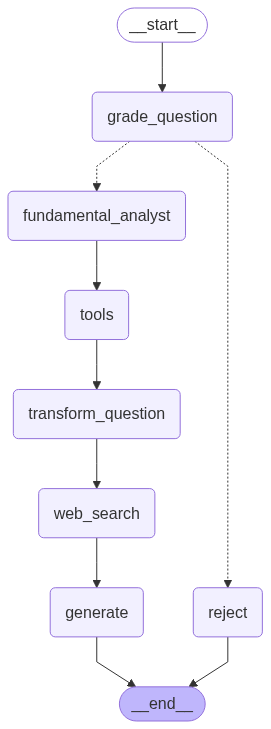

In [315]:
# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [316]:
from pprint import pprint
    
# Test inputs
inputs = {
    "question": "What is current price of Tesla?",
    "messages": [],
    "news": [],
    "Question_valid": "",
    "stock": "",
    "company_name": "",
    "generation": ""
}

In [317]:
print("Starting Financial Analysis...")
    
final_result = None
for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}' completed")
        final_result = value
    print("---")

if final_result and "generation" in final_result:
    print("\n=== FINAL ANALYSIS ===")
    print(final_result["generation"])
else:
    print("\n=== ERROR ===")
    print("No final generation produced")

Starting Financial Analysis...
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: Question IS RELEVANT---
---EXTRACTED COMPANY: Tesla (TSLA)---
Node 'grade_question' completed
---
---FUNDAMENTAL ANALYST---
Node 'fundamental_analyst' completed
---


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_20564\1319658027.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed


Node 'tools' completed
---
---TRANSFORMER QUERY---
---NEW QUESTION---
Tesla news affecting stock price last month
Node 'transform_question' completed
---
---WEB SEARCH---
Node 'web_search' completed
---
---GENERATE FINAL ANALYSIS---
Node 'generate' completed
---

=== FINAL ANALYSIS ===
Based on the extremely limited data provided (0 tool responses and 1 news source), a comprehensive analysis for Tesla (TSLA) is severely constrained. This analysis will highlight the available information and explicitly state what cannot be determined due to data scarcity.

---

### Comprehensive Analysis for Tesla (TSLA)

**Data Available:**
*   **Tools Data:** 0 tool responses (No stock price, technical indicators, or financial metrics)
*   **News Data:** 1 news source (Reuters, Jan 30, 2024, regarding Musk's intention to move legal home to Texas)

---

#### 1. Stock Price Analysis

**Due to the absence of any tool responses, no stock price data is available.** This means we cannot analyze:
*   Current

In [318]:
from pprint import pprint
    
# Test inputs
inputs = {
    "question": "Who is the CEO of Tesla?",
    "messages": [],
    "news": [],
    "Question_valid": "",
    "stock": "",
    "company_name": "",
    "generation": ""
}

In [319]:
print("Starting Financial Analysis...")
    
final_result = None
for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}' completed")
        final_result = value
    print("---")

if final_result and "generation" in final_result:
    print("\n=== FINAL ANALYSIS ===")
    print(final_result["generation"])
else:
    print("\n=== ERROR ===")
    print("No final generation produced")

Starting Financial Analysis...
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: Question IS NOT RELEVANT---
Node 'grade_question' completed
---
---REJECTING: Not a finance stock question---
Node 'reject' completed
---

=== FINAL ANALYSIS ===
This question is not related to financial stock analysis.


In [320]:
from pprint import pprint
    
# Test inputs
inputs = {
    "question": "what is stock price of Amazon?",
    "messages": [],
    "news": [],
    "Question_valid": "",
    "stock": "",
    "company_name": "",
    "generation": ""
}

In [321]:
print("Starting Financial Analysis...")
    
final_result = None
for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}' completed")
        final_result = value
    print("---")

if final_result and "generation" in final_result:
    print("\n=== FINAL ANALYSIS ===")
    print(final_result["generation"])
else:
    print("\n=== ERROR ===")
    print("No final generation produced")

Starting Financial Analysis...
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: Question IS RELEVANT---
---EXTRACTED COMPANY: Amazon (AMZN)---
Node 'grade_question' completed
---
---FUNDAMENTAL ANALYST---
Node 'fundamental_analyst' completed
---


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_20564\1319658027.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed


Node 'tools' completed
---
---TRANSFORMER QUERY---
---NEW QUESTION---
What recent news about Amazon has influenced its stock price (rise or fall) in the past month?
Node 'transform_question' completed
---
---WEB SEARCH---
Node 'web_search' completed
---
---GENERATE FINAL ANALYSIS---
Node 'generate' completed
---

=== FINAL ANALYSIS ===
Based on the information provided, which states "Tools Data Available: 0 tool responses" and "News Data Available: 1 news sources" (without the actual content of the news), a comprehensive analysis with actionable insights for Amazon (AMZN) is severely limited.

**Crucially, without any specific financial metrics, stock price data, technical indicator readings, or the actual content of the news source, it is impossible to provide a meaningful and actionable analysis.**

Therefore, the following sections will explain what *would* be analyzed if the data were available, and highlight the current limitations.

---

### Comprehensive Analysis for Amazon (AMZ

In [322]:
from pprint import pprint
    
# Test inputs
inputs = {
    "question": "Shall I buy dollar stocks or wait?",
    "messages": [],
    "news": [],
    "Question_valid": "",
    "stock": "",
    "company_name": "",
    "generation": ""
}

In [323]:
print("Starting Financial Analysis...")
    
final_result = None
for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}' completed")
        final_result = value
    print("---")

if final_result and "generation" in final_result:
    print("\n=== FINAL ANALYSIS ===")
    print(final_result["generation"])
else:
    print("\n=== ERROR ===")
    print("No final generation produced")

Starting Financial Analysis...
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: Question IS RELEVANT---
---EXTRACTED COMPANY: UNKNOWN (UNKNOWN)---
Node 'grade_question' completed
---
---FUNDAMENTAL ANALYST---
Node 'fundamental_analyst' completed
---
Node 'tools' completed
---
---TRANSFORMER QUERY---
---NEW QUESTION---
What recent company news has influenced US stock price movements in the last month?
Node 'transform_question' completed
---
---WEB SEARCH---
Node 'web_search' completed
---
---GENERATE FINAL ANALYSIS---
Node 'generate' completed
---

=== FINAL ANALYSIS ===
**Comprehensive Analysis for UNKNOWN (UNKNOWN)**

**Overview:**
This analysis is severely limited by the lack of specific data for the entity "UNKNOWN (UNKNOWN)". No tool responses were available for financial metrics, stock prices, or technical indicators. Only one news source was identified, and without its specific content, its relevance or impact cannot be assessed. Therefore, a comprehensive analysi